# Overview
This notebook will demonstrate the preprocessing of scRNA-seq data about mouse hematopoietic stem cells differentiation.
The original data is obtained from: *Nestorowa, S., Hamey F.K., Pijuan Sala B., et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood, 128(8): e20-e31 (2016).* <https://doi.org/10.1182/blood-2016-05-716480>


### Contents
- [1. Load data](#section1)
- [2. Convert Ensembl ID to gene symbol](#section2)
- [3. Define cell labels](#section3)
- [4. Make Anndata object](#section4)
- [5. Filtering, normalization and log transformation](#section5)
- [6. High variable genes](#section6)
- [7. PCA, KNN-graph and cell clustering](#section7)
- [8. Dimensionality reduction and visualization](#section8)
- [9. Trajectory inference and differential expression analysis](#section9)
- [10. Save the preprocessed data](#section10)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")
import cefcon as cf

In [2]:
subset_adata.raw = subset_adata.copy()
subset_adata.layers['raw_count'] = subset_adata.raw.X.copy()

# Normalization
sc.pp.normalize_total(subset_adata, target_sum=1e4)

sc.settings.set_figure_params(dpi=80,
                              dpi_save=300,
                              frameon=False,
                              figsize=(4, 4),
                              fontsize=13,
                              facecolor='white',
                              color_map='viridis_r',
                              )

# Reset random seed
np.random.seed(2022)

In [3]:
subset_adata = sc.read("../../h5ad/v3_allGenes_myeloid_unintegrated_annotated.h5ad")
subset_adata

AnnData object with n_obs × n_vars = 382320 × 32914
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'unintegrated_clusters', 'seurat_clusters', 'disease.patient', 'celltypes', 'celltypes.disease', 'celltypes.disease.state'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_counts.2_variance', 'vf_vst_counts.2_variance.expected', 'vf_vst_counts.2_variance.standardized', 'vf_vst_counts.2_variable', 'vf_vst_counts.2_rank', 'vf_vst_counts.3_mean', 'vf_vst_counts.3_variance', 'vf_vst_counts.3_variance.expected', 'vf_vst_counts.3_variance.standardized', 'vf_vst_counts.3_variable', 'vf_vst_counts.3_rank', 'vf_vst_counts.4_mean', 'vf_vst_counts.4_variance', 'vf_vst_counts.4_variance.expected', 'vf_vst

In [4]:
# Define the disease states you want to include
disease_states_to_include = ['Classical']  # Replace with your specific disease states

# Subset the AnnData object based on the disease state metadata
subset_adata = subset_adata[subset_adata.obs['celltypes'].isin(disease_states_to_include)]

In [5]:
# Define the disease states you want to include
disease_states_to_include = ['progressor', 'RR']  # Replace with your specific disease states

# Subset the AnnData object based on the disease state metadata
subset_adata = subset_adata[subset_adata.obs['prog'].isin(disease_states_to_include)]

In [6]:
n_cells_downsample = 10000
if subset_adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(subset_adata, n_obs=n_cells_downsample, random_state=123)

In [7]:
import os


In [8]:
# Log transformation
sc.pp.log1p(subset_adata)
subset_adata.layers['log_transformed'] = subset_adata.X.copy()


# Select the top 3,000 highly variable genes
sc.pp.highly_variable_genes(subset_adata, n_top_genes=3000)
subset_adata = subset_adata[:, subset_adata.var.highly_variable]
sc.pp.normalize_total(subset_adata, target_sum=1e4) # renormalize after filtering
#sc.pp.scale(adata, max_value=10)
sc.tl.pca(subset_adata)
sc.pp.neighbors(subset_adata, n_neighbors=10, n_pcs=35)
sc.tl.leiden(subset_adata, resolution=0.7)
# Use force-directed graph drawing
sc.tl.draw_graph(subset_adata)

In [11]:
subset_adata

AnnData object with n_obs × n_vars = 10000 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'unintegrated_clusters', 'seurat_clusters', 'disease.patient', 'celltypes', 'celltypes.disease', 'celltypes.disease.state', 'leiden'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_counts.2_variance', 'vf_vst_counts.2_variance.expected', 'vf_vst_counts.2_variance.standardized', 'vf_vst_counts.2_variable', 'vf_vst_counts.2_rank', 'vf_vst_counts.3_mean', 'vf_vst_counts.3_variance', 'vf_vst_counts.3_variance.expected', 'vf_vst_counts.3_variance.standardized', 'vf_vst_counts.3_variable', 'vf_vst_counts.3_rank', 'vf_vst_counts.4_mean', 'vf_vst_counts.4_variance', 'vf_vst_counts.4_variance.expected',

In [10]:
subset_adata.write_h5ad("../../h5ad/v3_3KHVGs_classial_Prog_RR_subset_cefcon.h5ad")

In [73]:
adata = cf.datasets.mouse_hsc_nestorowa16()
# Filtering
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata = adata[:, ~adata.var['mt']]

adata.raw = adata.copy()
adata.layers['raw_count'] = adata.raw.X.copy()

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transformation
sc.pp.log1p(adata)
adata.layers['log_transformed'] = adata.X.copy()

# Select the top 3,000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='cell_ranger')
adata = adata[:, adata.var.highly_variable]
sc.pp.normalize_total(adata, target_sum=1e4) # renormalize after filtering
#sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=35)
sc.tl.leiden(adata, resolution=0.7)
# Use force-directed graph drawing
sc.tl.draw_graph(adata)


Load mouse_hsc_nestorowa16_v0.h5ad


In [57]:
subset_adata

AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'GEM', 'prog', 'disease', 'sex', 'pair', 'age', 'edss', 'disease.state', 'prog_sex', 'disease_sex', 'disease.state_sex', 'unintegrated_clusters', 'seurat_clusters', 'disease.patient', 'celltypes', 'celltypes.disease', 'celltypes.disease.state', 'leiden'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_counts.2_variance', 'vf_vst_counts.2_variance.expected', 'vf_vst_counts.2_variance.standardized', 'vf_vst_counts.2_variable', 'vf_vst_counts.2_rank', 'vf_vst_counts.3_mean', 'vf_vst_counts.3_variance', 'vf_vst_counts.3_variance.expected', 'vf_vst_counts.3_variance.standardized', 'vf_vst_counts.3_variable', 'vf_vst_counts.3_rank', 'vf_vst_counts.4_mean', 'vf_vst_counts.4_variance', 'vf_vst_counts.4_variance.expected', 

In [82]:
adata.var_names

Index(['Gnai3', 'Apoh', 'Narf', 'Cav2', 'Klf6', 'Slc22a18', 'Gmpr', 'Tpd52l1',
       'Alox12', 'Mx1',
       ...
       'Pcdhga7', 'Pcdhga4', 'Pcdhga6', 'Pcdha8', 'Pcdhga8', 'Pcdhgb7',
       'Pcdha2', 'Trdc', 'Iglc3', 'Iglc1'],
      dtype='object', length=3000)

In [77]:
subset_adata.layers['log_transformed']

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 14827604 stored elements and shape (5000, 32914)>

In [83]:
    exp_normalized = adata.layers['log_transformed']

    # The normalized and log transformed data is used for MAST
    normalized_counts = pd.DataFrame(exp_normalized,
                                     index=adata.var_names,
                                     columns= adata.obs_names)
    # normalized_counts.to_csv(temp_R_dir + '/exp_normalized.csv

ValueError: Shape of passed values is (1645, 1), indices imply (3000, 1645)

In [85]:
import cefcon as cf
temp_R_dir = 'cefcon_test_out2'
os.makedirs(temp_R_dir, exist_ok=True)
cf.utils.prepare_data_for_R(subset_adata, temp_R_dir, reducedDim='X_draw_graph_fa', cluster_label='prog')
cf.utils.process_Slingshot_MAST_R(temp_R_dir, split_num=4, start_cluster=start_cluster, end_cluster=end_cluster)

ValueError: Shape of passed values is (5000, 1), indices imply (5000, 32914)

<a id="section9"></a>
## 9. Trajectory inference and differential expression analysis

CEFCON will construct a cell-lineage-specific GRN for each trajectory, so obtaining developmental trajectories is necessary before doing this. We also suggest considering the differential expression levels of genes along individual trajectories.

We have provided functions that call R to run [Slingshot](https://github.com/kstreet13/slingshot) for obtaining trajectory information and [MAST](https://github.com/RGLab/MAST/) for obtaining differential expression information. To do this, the required R packages should be first installed in the R environment, as follows:
```R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("slingshot", "MAST"))
```
&nbsp;
Then, call the R script in python with the following functions:
```Python
import cefcon as cf
temp_R_dir = 'temp_nestorowa16_results'
os.makedirs(temp_R_dir, exist_ok=True)
cf.utils.prepare_data_for_R(adata, temp_R_dir, reducedDim='X_draw_graph_fa', cluster_label='leiden')
cf.utils.process_Slingshot_MAST_R(temp_R_dir, split_num=4, start_cluster=start_cluster, end_cluster=end_cluster)
```

Any other methods of obtaining trajectory and pseudo-time information can be used. If the developmental trajectories with pseudotime are given, we still provide functions that only use MAST to obtain differential expression information of genes. 
Here, we directly use the trajectory information obtained from [Beeline](https://doi.org/10.5281/zenodo.3701939), and then call the R script in python to obtain differential expression information of genes along each trajectory.


In [13]:
# Load pseudotime information for each lineage
cell_lineage_info = pd.DataFrame(np.zeros((len(cell_labels),3)),
                                 index=cell_labels.index,
                                 columns=['E_pseudotime','GM_pseudotime','L_pseudotime'])
for d in ['E','GM','L']:
    l = pd.read_csv('./mHSC_Nestorowa16_data/PseudoTime_{}.csv'.format(d),
                    index_col=0)
    l.index = ['{}-{}'.format(*(i.split('_',1))) if i.startswith('LT') else i
               for i in l.index]
    cell_lineage_info['{}_pseudotime'.format(d)] = l['PseudoTime']

adata.obs['ME_lineage'] = cell_lineage_info['E_pseudotime']
adata.obs['GM_lineage'] = cell_lineage_info['GM_pseudotime']
adata.obs['L_lineage'] = cell_lineage_info['L_pseudotime']

adata.uns['lineages'] = ['ME_lineage', 'GM_lineage', 'L_lineage']

In [14]:
# Obtain differential expression information of genes along each trajectory

temp_R_dir = 'temp_nestorowa16_results'
os.makedirs(temp_R_dir, exist_ok=True)

cf.utils.prepare_data_for_R(adata, temp_R_dir)
cf.utils.process_MAST_R(temp_R_dir, split_num=4)

Running MAST using: 'Rscript /home/wangpeizhuo/cefcon/MAST_script.R temp_nestorowa16_results 4'

It will take a few minutes ...
Done. The results are saved in 'temp_nestorowa16_results'.
      Differential expression information: 'DEgenes_MAST_sp4_<x>.csv'


In [15]:
# Add gene differential expression information into anndata
for lin in adata.uns['lineages']:
    DE_genes = pd.read_csv(temp_R_dir + f'/DEgenes_MAST_sp4_{lin}.csv', index_col=0)
    adata.var[lin+'_logFC'] = DE_genes['logFC']

Check the lineages:

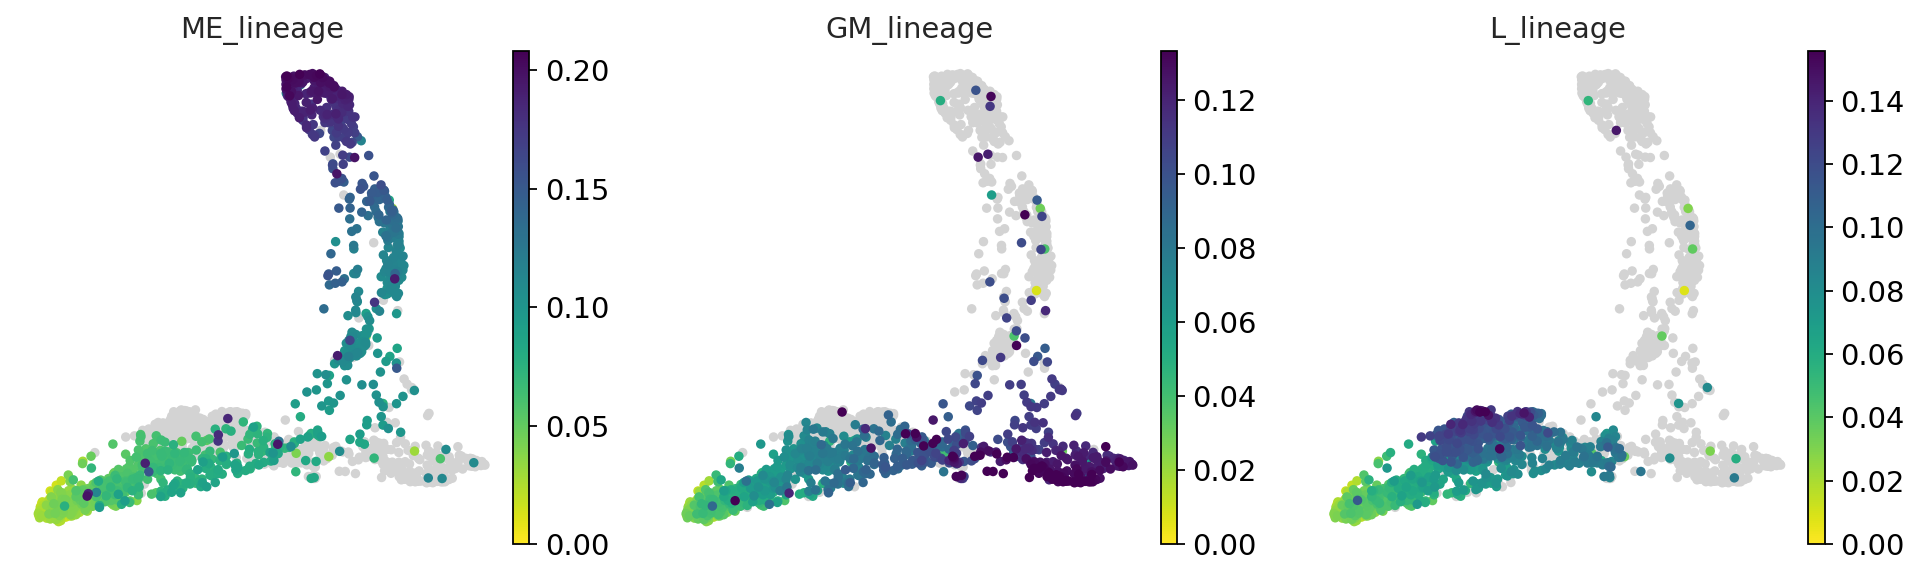

In [16]:
sc.pl.draw_graph(
    adata,
    color=adata.uns['lineages'],
    ncols=4,
    wspace=0.2,
)

<a id="section10"></a>
## 10. Save the preprocessed adata

In [17]:
adata.write_h5ad("mouse_HSC_nestorowa16_v1.h5ad")